<a href="https://colab.research.google.com/github/Fortuz/acdc_sr/blob/main/draw_recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# szukseges importok
import pandas as pd
from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
import json
import math
import ast
import random
import tensorflow as tf
from PIL import Image
from abc import abstractmethod
import tensorflowjs as tfjs
from tensorflow.keras.layers import LSTM, Dense, Layer, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

In [2]:
# csatlakozas a drivera
drive.mount('/content/drive')
# globalis valtozok
train_amount = 10000
test_amount = 1000
directory_path = '/content/drive/MyDrive/Draw_Recognition/train_simplified/'
preproccessed_train_directory_path = '/content/drive/MyDrive/Draw_Recognition/preproccessed_train_data'
preproccessed_test_directory_path = '/content/drive/MyDrive/Draw_Recognition/preproccessed_test_data'
models_directory_path = '/content/drive/MyDrive/Draw_Recognition/models/'
max_length = 150  # ilyen hosszura fogjuk kitolni a pontsorozatokat
num_classes = 20 # kategoriak szama
model_ckpt = 'lstm_attention_model_weights.h5'
cnn_model_ckpt = 'cnn_model_weights2.h5'

Mounted at /content/drive


In [ ]:
class DataPrepper():
  def __init__(self, num_classes, directory_path, train_directory, test_directory, train_amount, test_amount):
    self.num_classes = num_classes
    self.directory_path = directory_path
    self.train_directory = train_directory
    self.test_directory = test_directory
    self.train_amount = train_amount
    self.test_amount = test_amount

  def download_dataset(self):
    # kaggle csatlakozas, dataset letoltese drivera
    files.upload()
    ! mkdir ~/.kaggle
    ! cp kaggle.json ~/.kaggle/
    ! chmod 600 /root/.kaggle/kaggle.json
    %cd /content/drive/My\ Drive/Draw_Recognition
    !pip install --upgrade --force-reinstall --no-deps kaggle
    ! kaggle competitions download -c quickdraw-doodle-recognition
    drive.mount('/content/drive')
    ! unzip quickdraw-doodle-recognition.zip

  # fuggveny, ami beolvas egy csv-t es feldolgozza
  def read_format_csv(self, csv_name, word_id):
    csv = pd.read_csv(csv_name,on_bad_lines="skip", engine="python") # beolvasas
    csv = csv.drop('timestamp', axis=1) # felesleges oszlop
    csv = csv.drop('countrycode', axis=1) # felesleges oszlop
    csv = csv.drop('key_id', axis=1) # felesleges oszlop
    csv = csv[csv['recognized'] == True] # csak azokat tartsuk meg, amelyek felismerhetoen vannak rajzolva
    csv = csv.drop('recognized',axis =1) # felesleges oszlop
    csv['word_id'] = word_id # szo azonosito hozzadas
    csv = csv.sample(frac=1) # megkeveres
    return csv.head(self.train_amount+self.test_amount) # elso X sor megtartasa

  def get_rates(self):
    # feldolgozza a datasetet es elmenti, hogy milyen aranyban felismert a rajz
    self.rates = [] # aranyok
    csv_files = [file for file in os.listdir(self.directory_path) if file.endswith('.csv')] # fajlok nevei
    for csv_file in tqdm(csv_files):
      csv = pd.read_csv(os.path.join(self.directory_path, csv_file),on_bad_lines="skip", engine="python") # fajl beolvasasa
      rate = len(csv[csv['recognized'] == True]) / len(csv) # arany meghatarozasa
      self.rates.append((csv_file, rate)) # (fajl neve, felismert arany) tuple hozzaadas a listahoz
    exclude = ['grass.csv','zigzag.csv','line.csv','triangle.csv','vase.csv','cloud.csv','rain.csv']
    self.rates = [item for item in self.rates if item[0] not in exclude]

  def get_categories(self):
    # uj kategoriak meghatarozasa az aranyok alapjan
    self.categories = sorted(self.rates, key=lambda x: x[1], reverse=True)[0:self.num_classes]

  def write_data(self):
    # elmentjuk az uj kategoriak csv file-jat feldolgozva es zippelve
    test_dataframe = pd.DataFrame() # pandas dataframe
    for i,cat in tqdm(enumerate(self.categories)):
      csv = self.read_format_csv(os.path.join(self.directory_path, cat[0]), i) # beolvassuk az uj kategoria szerinti csv-t
      csv.head(train_amount).to_csv(os.path.join(self.train_directory,f'train_{cat[0]}.gz'), index=False, compression='gzip') # az elso train_amount sort tartjuk meg es kiirjuk
      test_dataframe = pd.concat([test_dataframe,csv[self.train_amount: self.train_amount + self.test_amount]]) # a teszt adatokat kigyujtjuk
    test_dataframe.sample(frac=1).to_csv(os.path.join(self.test_directory, 'test_data.gz'), index=False, compression='gzip') # teszt adatokat megkeverjuk es kiirjuk

  def run(self, need_download=False):
    if need_download:
      self.download_dataset()
    self.get_rates()
    self.get_categories()
    self.write_data()

In [ ]:
# csak elso futtatasnal
dataprepper = DataPrepper(num_classes, directory_path, preproccessed_train_directory_path,
                          preproccessed_test_directory_path, train_amount, test_amount)
dataprepper.run()

100%|██████████| 340/340 [02:26<00:00,  2.33it/s]
20it [00:35,  1.76s/it]


In [ ]:
class SelfAttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(SelfAttentionLayer, self).__init__()

    def get_positional_encoding(self):
        position = np.arange(self.seq_length)[:, np.newaxis]
        div_term = np.exp(np.arange(0, self.hidden_units, 2) * -(np.log(10000.0) / self.hidden_units))
        pe = np.zeros((self.seq_length, self.hidden_units))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        return tf.constant(pe, dtype=tf.float32)

    def build(self, input_shape):
        self.hidden_units = input_shape[-1]
        self.seq_length = input_shape[1]
        self.pos_encoding = self.get_positional_encoding()
        self.key = tf.keras.layers.Dense(self.hidden_units)
        self.query = tf.keras.layers.Dense(self.hidden_units)
        self.value = tf.keras.layers.Dense(self.hidden_units)

    def call(self, x, mask=None):
        seq_length = tf.shape(x)[1]
        x += self.pos_encoding[:seq_length, :]
        keys = self.key(x)
        queries = self.query(x)
        values = self.value(x)
        scores = tf.matmul(queries, keys, transpose_b=True)
        scores = scores / tf.math.sqrt(tf.cast(self.hidden_units, tf.float32))
        weights = tf.nn.softmax(scores, axis=-1)
        output = tf.matmul(weights, values)

        return output

In [3]:
class NeuralNetwork():
  def __init__(self, num_classes, models_path, checkpoint_directory, train_directory, test_directory) -> None:
    self.num_classes = num_classes
    self.models_path = models_path
    self.checkpoint_directory = checkpoint_directory
    self.train_directory = train_directory
    self.test_directory = test_directory

  def get_checkpoint(self, patience):
    self.checkpoint = ModelCheckpoint(os.path.join(self.models_path,self.checkpoint_directory), monitor='val_loss', save_best_only=True, save_weights_only=True)
    self.early_stopping = EarlyStopping(monitor='val_loss', patience=patience)

  # kategoria neve a sorszamabol
  def category_name_by_id(self, id):
    return str(self.dataframe['word'][self.dataframe['word_id'] == id].values[0])

  def get_dataframe(self):
    # beolvassuk a mar elore feldolgozott adatokat es megkeverjuk
    self.dataframe = pd.DataFrame()
    csv_files = [file for file in os.listdir(self.train_directory) if file.endswith('.gz')]
    for csv_file in tqdm(csv_files):
      csv = pd.read_csv(os.path.join(self.train_directory, csv_file), compression='gzip')
      self.dataframe = pd.concat([self.dataframe, csv])
    for i in range(0,5):
      self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)

  @abstractmethod
  def process_points(self,row):
    pass

  @abstractmethod
  def get_model(self):
    pass

  @abstractmethod
  def get_train_data(self):
    pass

  @abstractmethod
  def get_test_data(self):
    pass

  def load_data(self, test_only=False):
    self.get_dataframe()
    self.dataframe['processed_points'] = self.dataframe['drawing'].apply(self.process_points)
    if not test_only:
      self.get_train_data()
    self.get_test_data()

  def load_model(self):
    self.get_model()

  def load_weights(self):
    self.model.load_weights(os.path.join(self.models_path,self.checkpoint_directory))

  def draw_samples(self):
    test_data = self.dataframe
    fig, axs = plt.subplots(5, 1, figsize=(8, 30))
    for drawing_ind in range(0,5):
      for i, (x, y) in enumerate(json.loads(test_data['drawing'][drawing_ind])):
          axs[drawing_ind].plot(x, y, marker='o')
          for j, (x_coord, y_coord) in enumerate(zip(x, y)):
              axs[drawing_ind].annotate(str(j+1), (x_coord, y_coord), textcoords="offset points", xytext=(5,-5), ha='center')
      axs[drawing_ind].invert_yaxis()
      axs[drawing_ind].set_title(test_data['word'][drawing_ind])
      axs[drawing_ind].set_xticks([])
      axs[drawing_ind].set_yticks([])
    plt.show()

  def train(self, epochs, batch_size):
    self.history = self.model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size, validation_data=(self.X_val, self.y_val), callbacks=[self.checkpoint, self.early_stopping])
    self.val_loss, self.val_acc = self.model.evaluate(self.X_val, self.y_val, verbose=2)
    print(self.val_loss, self.val_acc)

  def plot_train_results(self):
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs[0].plot(self.history.history['loss'], label="Train")
    axs[0].plot(self.history.history['val_loss'], label='Validation')
    axs[0].set_title('Losses')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend()


    axs[1].plot(self.history.history['accuracy'], label='Train')
    axs[1].plot(self.history.history['val_accuracy'], label='Validation')
    axs[1].set_title('Accuracies')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

  def predict(self, x):
    self.y_pred = self.model.predict(x)
    self.y_pred = np.argmax(self.y_pred, axis = 1)
    self.success_rate = np.sum(self.y_pred == self.y_test) / len(self.y_pred)
    return self.y_pred, self.success_rate

  def test_results(self):
    print('success rate: ',self.success_rate)
    confusion_matrix = tf.math.confusion_matrix(self.y_test,self.y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title("Confusion matrix")
    plt.show()

  def random_test(self):
    fig, axs = plt.subplots(5, 1, figsize=(5, 20))
    for drawing_ind in range(0,5):
      index = random.randint(1,len(self.test_data))
      for (x, y) in json.loads(self.test_data['drawing'][index]):
          axs[drawing_ind].plot(x, y, color='black')
      axs[drawing_ind].invert_yaxis()
      axs[drawing_ind].set_title('Predicted: '+str(self.category_name_by_id(self.y_pred[index])+' | Real: '+str(self.category_name_by_id(self.y_test[index]))))
      axs[drawing_ind].set_xticks([])
      axs[drawing_ind].set_yticks([])
    plt.show()

  def download_test_data(self):
    # teszt adatok
    self.test_data = pd.read_csv(os.path.join(self.test_directory, 'test_data.gz'), compression='gzip') # teszt adatok betoltese
    test_list = []
    self.test_data['processed_points'] = self.test_data['drawing'].apply(self.process_points) # teszt adatokhoz [(x,y,_)] tomb meghatarozasa
    self.y_test = self.test_data['word_id'].values


In [ ]:
class LSTMNetwork(NeuralNetwork):
  def __init__(self, num_classes, models_path, checkpoint_directory, train_directory, test_directory) -> None:
    super().__init__(num_classes, models_path, checkpoint_directory, train_directory, test_directory)

  # [(x,y,1)] listat csinalunk a sorra
  def process_points(self,row):
      # A pontsorozatok átalakítása a string formátumból listává
      points = ast.literal_eval(row)
      # Többdimenziós listából (x, y, 1) pontokká alakítás
      combined_points = []
      for segment in points:
          x = segment[0]
          y = segment[1]
          z = [1 for i in range(len(x))]
          combined_points.extend(list(zip(x, y,z)))
      return combined_points

  def get_train_data(self):
    # X lesz a tanitohhalmaz, y a hozza tartozo cimkehalmaz
    X = list(self.dataframe['processed_points'])
    y = self.dataframe['word_id'].values

    # felosztjuk tanitasi es validacios halmazokra az X-et
    self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X, y, test_size=0.2)

    # kitoljuk az osszes pontsorozatot ugy hogy egyforma hosszuak legyenek
    # numpy tombok lesznek
    self.X_train = pad_sequences(self.X_train, maxlen=max_length, padding='post', dtype='int32')
    self.X_val = pad_sequences(self.X_val, maxlen=max_length, padding='post', dtype='int32')

  def get_model(self):
    hidden_units = 64
    # lstm modell letrehozasa
    self.model = Sequential([
        LSTM(units=hidden_units, input_shape=(max_length, 3),return_sequences=True),
        SelfAttentionLayer(),
        tf.keras.layers.Flatten(),
        Dense(num_classes, activation='softmax')
    ])
    self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    self.model.build(input_shape=(None,max_length,3))
    self.get_checkpoint(5)
    self.model.summary()

  def get_test_data(self):
    self.download_test_data()
    self.x_test = list(self.test_data['processed_points'])
    self.x_test = pad_sequences(self.x_test, maxlen=max_length, padding='post', dtype='int32')

  def experiment(self, index):
    chosen_index = index
    drawing = self.test_data['drawing'][chosen_index]
    name = self.test_data['word'][chosen_index]
    drawing_list = json.loads(drawing)
    length = len(drawing_list)
    cols = 4
    rows = None
    if math.ceil(length/cols) > 1:
      rows = math.ceil(length/cols)
    else:
      rows = 2
    fig, axs = plt.subplots(rows, cols, figsize=(10, 8))
    c = 0
    print(self.test_data['word'][chosen_index])
    for i in range(0,rows):
      for k in range(0,cols):
        temp_drawing = drawing_list[:]
        if c >= length:
          break
        temp_drawing.pop(c)
        temp_proccessed_points = self.process_points(str(temp_drawing))
        for (x, y) in temp_drawing:
            axs[i,k].plot(x, y, color='black')
        axs[i,k].invert_yaxis()
        temp_proccessed_points = pad_sequences([temp_proccessed_points], maxlen=max_length, padding='post', dtype='int32')
        prediction, rate = self.predict(temp_proccessed_points)
        name =self.category_name_by_id(prediction[0])
        axs[i,k].set_title(name)
        axs[i,k].set_xticks([])
        axs[i,k].set_yticks([])
        c+=1

In [21]:
class ConvolutionalNetwork(NeuralNetwork):
  def __init__(self, num_classes, models_path, checkpoint, train_directory, test_directory, dimensions) -> None:
    super().__init__(num_classes, models_path, checkpoint, train_directory, test_directory)
    self.dimensions = dimensions

  def convert_to_tfjs(self):
      tfjs.converters.save_keras_model(self.model, self.models_path)

  # [(x,y)] listat csinalunk a sorra
  def process_points(self,row):
      # A pontsorozatok átalakítása a string formátumból listává
      points = ast.literal_eval(row)
      # Többdimenziós listából (x, y) pontokká alakítás
      combined_points = []
      for segment in points:
          x = segment[0]
          y = segment[1]
          combined_points.extend(list(zip(x, y)))
      return combined_points

  def get_matrix_from_points(self,array,index, df):
    points_with_ones = df['processed_points'][index]
    points = [(x, y) for x, y in points_with_ones]
    x, y = zip(*points)
    for i in range(len(x) - 1):
        num_points = max(abs(x[i+1] - x[i]), abs(y[i+1] - y[i])) * 10
        points_on_line = zip(np.linspace(x[i], x[i+1], num=num_points).astype(int),
                             np.linspace(y[i], y[i+1], num=num_points).astype(int))
        for point in points_on_line:
            array[point] = 1

  def get_model(self):
    self.model = Sequential()
    self.model.add(Conv2D(16, (3, 3),padding='same',input_shape=(self.dimensions[-2],self.dimensions[-1],1), activation='relu'))
    self.model.add(MaxPooling2D(pool_size=(2, 2)))


    self.model.add(Conv2D(32, (3, 3), padding='same', activation= 'relu'))
    self.model.add(Conv2D(32, (3, 3), padding='same', activation= 'relu'))
    self.model.add(MaxPooling2D(pool_size=(2, 2)))

    self.model.add(Conv2D(64, (3, 3), padding='same', activation= 'relu'))
    self.model.add(Conv2D(64, (3, 3), padding='same', activation= 'relu'))
    self.model.add(MaxPooling2D(pool_size =(2,2)))

    self.model.add(Conv2D(128, (3, 3), padding='same', activation= 'relu'))
    self.model.add(Conv2D(128, (3, 3), padding='same', activation= 'relu'))
    self.model.add(MaxPooling2D(pool_size =(2,2)))

    self.model.add(Conv2D(128, (3, 3), padding='same', activation= 'relu'))
    self.model.add(Conv2D(128, (3, 3), padding='same', activation= 'relu'))
    self.model.add(MaxPooling2D(pool_size =(2,2)))

    self.model.add(Dropout(0.1))
    self.model.add(Flatten())
    self.model.add(Dense(512, activation='tanh'))
    self.model.add(Dense(num_classes, activation='softmax'))
    self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    self.get_checkpoint(1)
    print(self.model.summary())

  def get_train_data(self):
    c=0
    X = np.zeros(self.dimensions, np.uint8)
    for i in tqdm(range(X.shape[0])):
      self.get_matrix_from_points(X[i,:,:],c, self.dataframe)
      c+=1
    y = self.dataframe['word_id'].values
    self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X, y, test_size=0.2)

  def get_test_data(self):
    self.download_test_data()
    c=0
    self.x_test = np.zeros((len(self.test_data),self.dimensions[-2],self.dimensions[-1]), np.uint8)
    for i in tqdm(range(self.x_test.shape[0])):
      self.get_matrix_from_points(self.x_test[i,:,:],c, self.test_data)
      c+=1

In [ ]:
lstm_model = LSTMNetwork(num_classes,models_directory_path, model_ckpt, preproccessed_train_directory_path, preproccessed_test_directory_path)
lstm_model.load_data(True)
lstm_model.load_model()
# lstm_model.train(50, 1000)
lstm_model.load_weights()

100%|██████████| 20/20 [00:00<00:00, 24.70it/s]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 150, 64)           17408     
                                                                 
 self_attention_layer (Self  (None, 150, 64)           12480     
 AttentionLayer)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 9600)              0         
                                                                 
 dense_2 (Dense)             (None, 20)                192020    
                                                                 
Total params: 221908 (866.83 KB)
Trainable params: 221908 (866.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


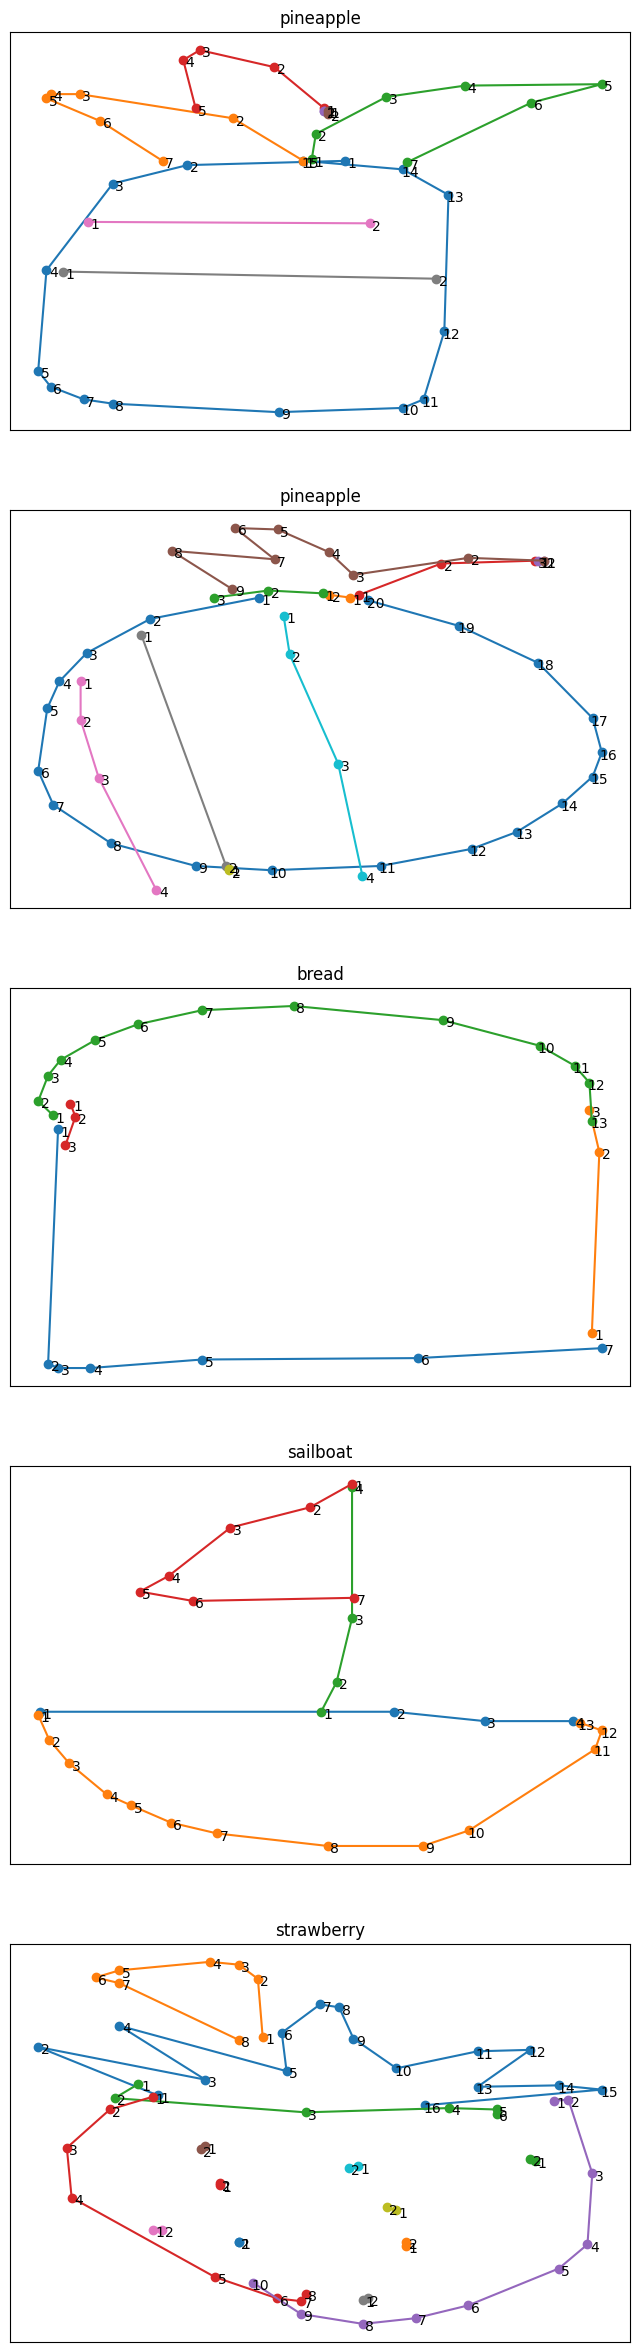

In [ ]:
lstm_model.draw_samples()

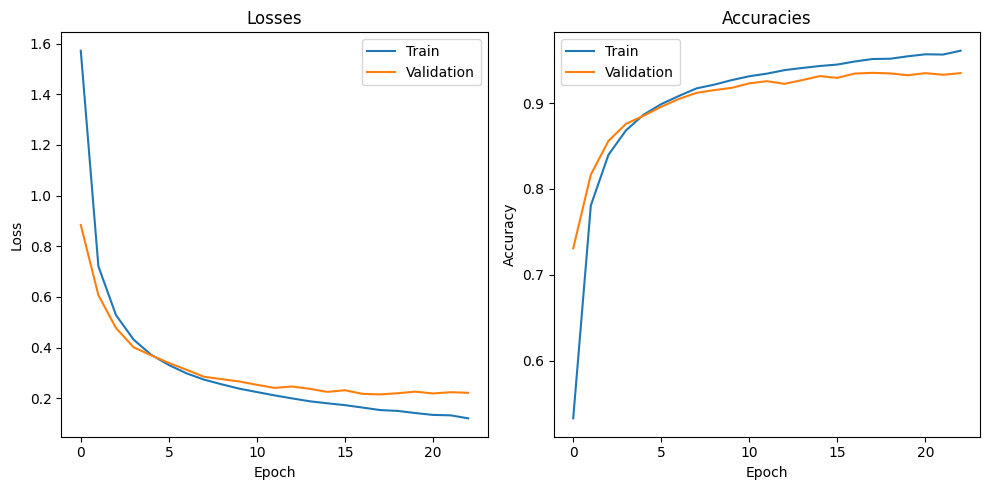

In [ ]:
lstm_model.plot_train_results()

625/625 [==============================] - 3s 2ms/step
success rate:  0.93605


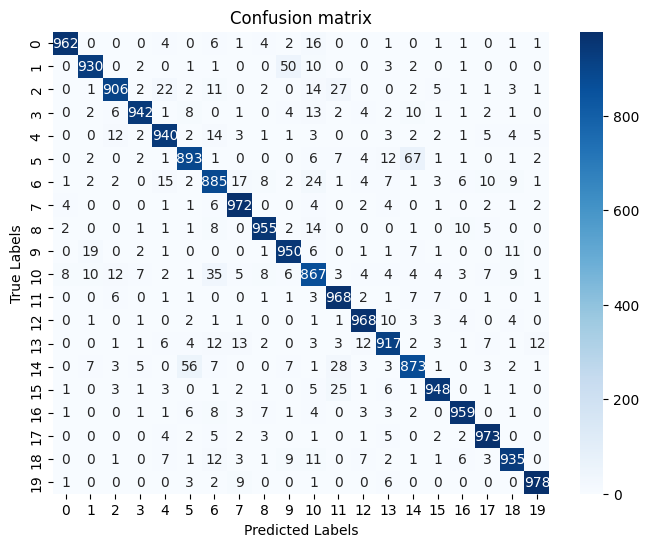

In [ ]:
lstm_model.predict(lstm_model.x_test)
lstm_model.test_results()

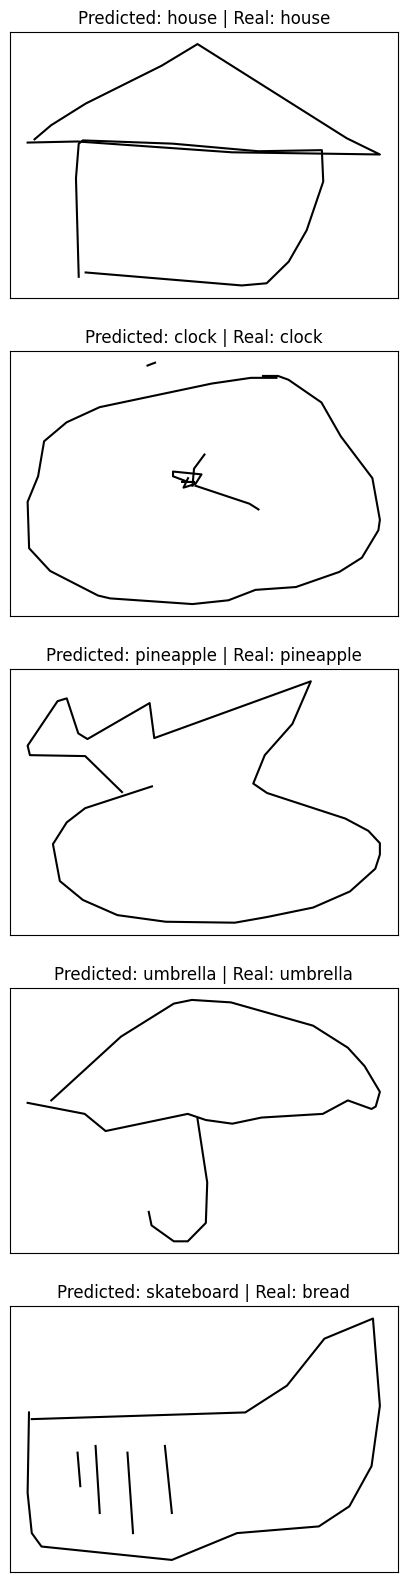

In [ ]:
lstm_model.random_test()

bicycle
1/1 [==============================] - 0s 32ms/step


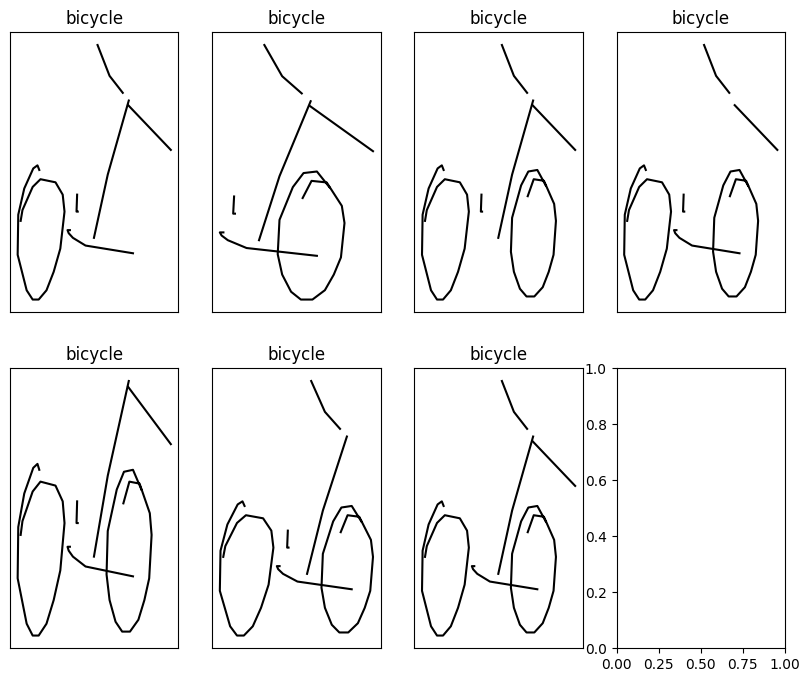

In [ ]:
lstm_model.experiment(3)

In [22]:
cnn_model = ConvolutionalNetwork(num_classes,models_directory_path, cnn_model_ckpt, preproccessed_train_directory_path,preproccessed_test_directory_path, (train_amount*num_classes,256,256))
cnn_model.load_data(True)
cnn_model.load_model()
# cnn_model.train(10, 200)
cnn_model.load_weights()


100%|██████████| 20000/20000 [01:38<00:00, 202.37it/s]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 64)       

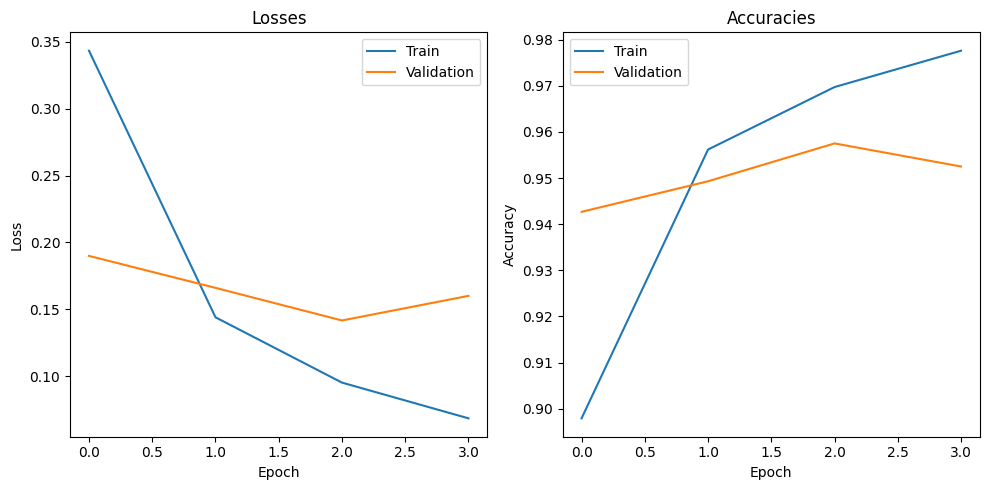

In [6]:
cnn_model.plot_train_results()

625/625 [==============================] - 3s 4ms/step
success rate:  0.95845


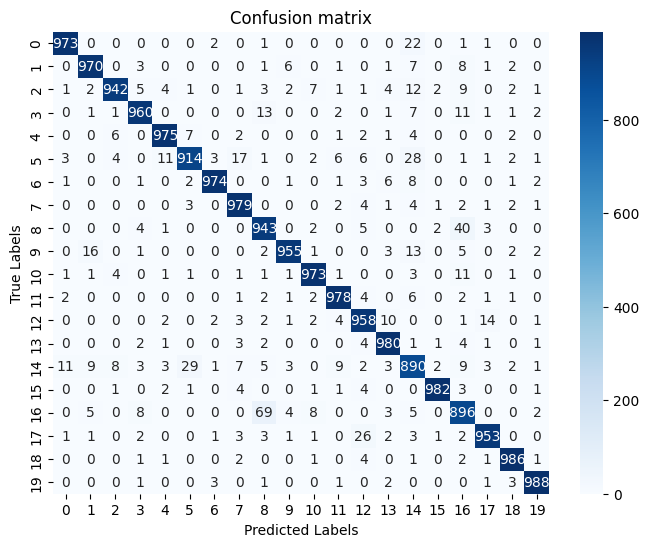

In [23]:
cnn_model.predict(cnn_model.x_test)
cnn_model.test_results()